# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import random 
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.metrics import roc_curve,accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# using SQLite Table to read data.

con = sqlite3.connect('drive/My Drive/FFRDB/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [0]:
final.sort_values('Time',inplace=True)
print(final.head(5))

          Id  ...                                               Text
1146    1245  ...  This was a really good idea and the final prod...
1145    1244  ...  I just received my shipment and could hardly w...
28086  30629  ...  Nothing against the product, but it does bothe...
28087  30630  ...  I love this stuff. It is sugar-free so it does...
38740  42069  ...  Fresh limes are underappreciated, but a joy to...

[5 rows x 10 columns]


In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
If your trying to do a low carb product.  This works out great.  There are receipies on tova's website on how to make poundcake, pancakes, and a variety of other items.  They turn out pretty great.<br /><br />Try it.  It's a great product.<br /><br /> ~Donna
The orange and lemon peels make this tea very hippy.  Despite  the initial oohing and ahing over the pretty blue flowers, this is a regrettable purchase.  I was hoping for a stronger bergamot component than Twinings' Earl Grey but instead I got something that seems very herbal.  Blech.  I disagree with the positive reviews.
I love these licorice.  Get licorice flavor--not just sugar with some flavor.  Very satisfying.


In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
If your trying to do a low carb product.  This works out great.  There are receipies on tova's website on how to make poundcake, pancakes, and a variety of other items.  They turn out pretty great.Try it.  It's a great product. ~Donna
The orange and lemon peels make this tea very hippy.  Despite  the initial oohing and ahing over the pretty blue flowers, this is a regrettable purchase.  I was hoping for a stronger bergamot component than Twinings' Earl Grey but instead I got something that seems very herbal.  Blech.  I disagree with the positive reviews.
I love these licorice.  Get licorice flavor--not just sugar with some flavor.  Very satisfying.


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

The orange and lemon peels make this tea very hippy.  Despite  the initial oohing and ahing over the pretty blue flowers, this is a regrettable purchase.  I was hoping for a stronger bergamot component than Twinings' Earl Grey but instead I got something that seems very herbal.  Blech.  I disagree with the positive reviews.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

The orange and lemon peels make this tea very hippy Despite the initial oohing and ahing over the pretty blue flowers this is a regrettable purchase I was hoping for a stronger bergamot component than Twinings Earl Grey but instead I got something that seems very herbal Blech I disagree with the positive reviews 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:15<00:00, 2936.79it/s]


In [0]:
preprocessed_reviews[1500]

'orange lemon peels make tea hippy despite initial oohing ahing pretty blue flowers regrettable purchase hoping stronger bergamot component twinings earl grey instead got something seems herbal blech disagree positive reviews'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

# [4] Featurization

### Loading tfidf and avg W2V pickles of 50k points

In [0]:
import pickle 
import os

dbfile1 = open('/content/drive/My Drive/FFRDB/tfidf_50k.pkl', 'rb')  
tfidf_sent_vectors = pickle.load(dbfile1)  


dbfile2 = open('/content/drive/My Drive/FFRDB/sent_vectors_50k.pkl', 'rb') 
sent_vectors= pickle.load(dbfile2)

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

### L1 Reg


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10, max_features= 5000)
vectorizer.fit(X_train) 
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(32249, 5000)
(13822, 5000)


In [0]:
b=[10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

param = {'alpha':b}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

L_SVM_L1=SGDClassifier(loss='hinge', penalty='l1', n_jobs=-1)
temp_gscv= GridSearchCV(L_SVM_L1,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.9min finished


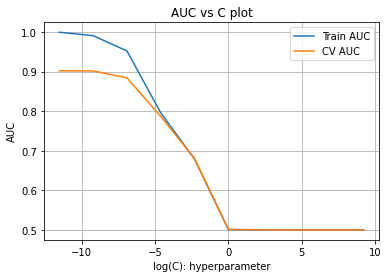

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(b),train_auc,label='Train AUC')
plt.plot(np.log(b),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
'''from the above graph taking  alpha = 0.001'''


from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

L_SVM_L1=SGDClassifier(loss='hinge', penalty='l1', alpha=0.001, n_jobs=-1)
L_SVM_L1.fit(X_train,y_train)
y_pred_tr = L_SVM_L1.decision_function(X_train)
y_pred_ts = L_SVM_L1.decision_function(X_test)

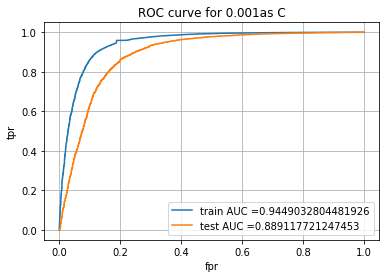

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (0.001)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.6890987204926737 for threshold 354.709
train
the maximum value of tpr*(1-fpr) 0.7884418949354984 for threshold 230.334


train Confusion Matrix


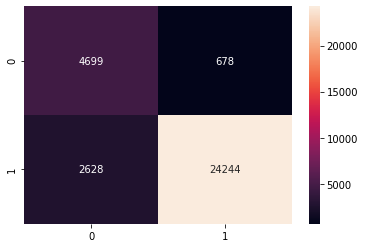

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


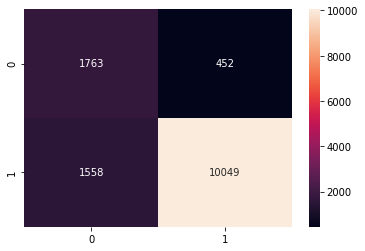

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 85.46%
Precision on test set: 95.70%
recall score on test set: 86.58%
f1 score on test set: 90.91%


In [0]:
count=0
value=[]
for i in L_SVM_L1.coef_.reshape(-1,1):
  count+=1
  value.extend(i)

x=vectorizer.get_feature_names()

features= pd.DataFrame({'feature_name':x,'value':value})

Top Most important features

In [0]:
features.sort_values(by = ['value'], ascending=False).head(10)

,feature_name,value
543,cakes,352.782905
3178,pasta,220.616778
4140,steeping,179.141488
24,acids,175.646968
1837,great,153.974761
327,best,131.198695
4331,taste tea,129.949369
1053,delicious,128.584951
3761,satisfies,126.039622
1667,gag,124.244681


Least Most important features

In [0]:
features.sort_values(by = ['value'], ascending=True).head(10)

,feature_name,value
545,calcium,-149.392735
4526,toxic,-135.018034
2738,naturals,-133.388752
233,away not,-109.130660
1125,disappointed,-98.842617
4901,worst,-93.419128
2242,label,-87.248897
2045,horrible,-84.721022
3657,returned,-83.308227
4645,unpleasant,-82.969421


#### L2 Reg

In [0]:
param = {'alpha':b}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

L_SVM_L2=SGDClassifier(loss='hinge', penalty='l2', n_jobs=-1)
temp_gscv= GridSearchCV(L_SVM_L2,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.1s finished


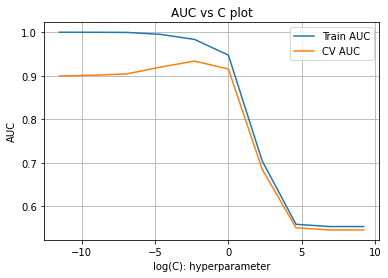

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(b),train_auc,label='Train AUC')
plt.plot(np.log(b),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
c=b
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)
local_c=list(c[i] for i in l)
print(f'all local differences {local_diff}')
print(f'all local max C {local_c}')

for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_c=c[l[v]]
print(f'best C to use = {c[l[v]]}')

all local differences [0.04959900937867445]
all local max C [0.1]
best cv score to use = 0.9335460417580169
best C to use = 0.1


In [0]:
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

L_SVM_L2=SGDClassifier(loss='hinge', penalty='l2', alpha=best_c, n_jobs=-1)
L_SVM_L2.fit(X_train,y_train)
y_pred_tr = L_SVM_L2.decision_function(X_train)
y_pred_ts = L_SVM_L2.decision_function(X_test)

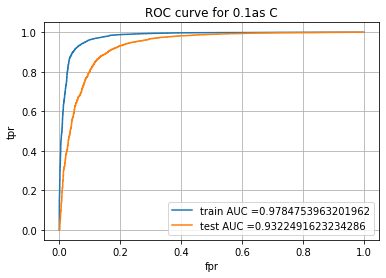

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.7604253757511084 for threshold 0.594
train
the maximum value of tpr*(1-fpr) 0.8743710254547515 for threshold 0.539


train Confusion Matrix


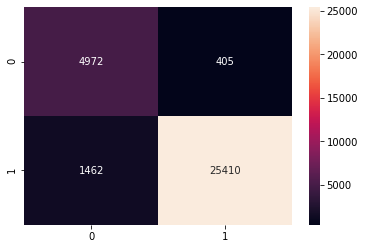

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


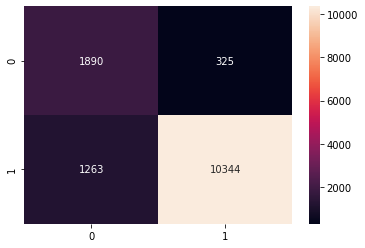

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 88.51%
Precision on test set: 96.95%
recall score on test set: 89.12%
f1 score on test set: 92.87%


In [0]:
count=0
value=[]
for i in L_SVM_L1.coef_.reshape(-1,1):
  count+=1
  value.extend(i)

x=vectorizer.get_feature_names()

features= pd.DataFrame({'feature_name':x,'value':value})

Top Most important features

In [0]:
features.sort_values(by = ['value'], ascending=False).head(10)

,feature_name,value
1053,delicious,590.310095
1837,great,580.106146
1762,good,562.901375
1569,folgers,562.159305
327,best,548.516297
4695,vanilla chai,528.378712
1855,great quality,439.076255
2458,love,400.724393
1347,excellent,398.328007
2484,loves,384.671929


Least Most important features

In [0]:
features.sort_values(by = ['value'], ascending=True).head(10)

,feature_name,value
1125,disappointed,-444.489876
4622,two stars,-395.336432
4901,worst,-384.270760
2969,not worth,-341.783732
235,awful,-312.266706
4987,yuck,-303.490760
3878,shells,-299.503194
2825,not,-284.470606
4398,terrible,-277.302093
4824,wheatgrass,-276.907725


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

#### L1 Reg

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
vectorizer.fit(X_train) 
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(32249, 5000)
(13822, 5000)


In [0]:
b=[10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

param = {'alpha':b}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

L_SVM_L1=SGDClassifier(loss='hinge', penalty='l1', n_jobs=-1)
temp_gscv= GridSearchCV(L_SVM_L1,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.7min finished


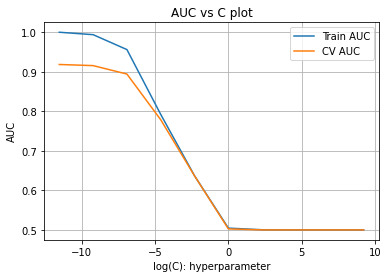

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(b),train_auc,label='Train AUC')
plt.plot(np.log(b),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
'''from the above graph choosing value of alpha as  0.001'''
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

L_SVM_L1=SGDClassifier(loss='hinge', penalty='l1', alpha=0.001, n_jobs=-1)
L_SVM_L1.fit(X_train,y_train)
y_pred_tr = L_SVM_L1.decision_function(X_train)
y_pred_ts = L_SVM_L1.decision_function(X_test)

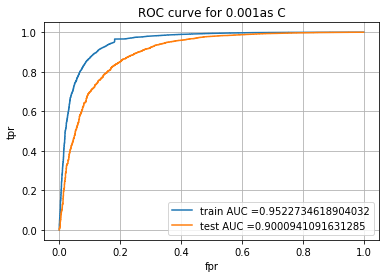

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (0.001)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.42535863681545016 for threshold 0.749
train
the maximum value of tpr*(1-fpr) 0.4340861584877714 for threshold 0.739


train Confusion Matrix


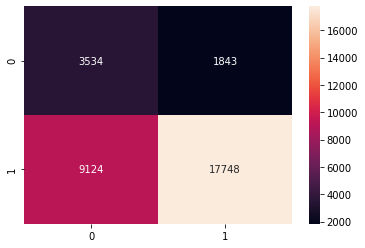

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


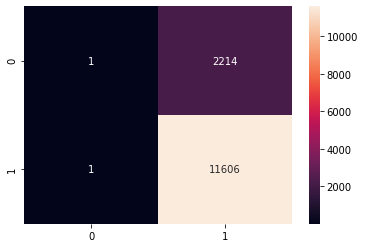

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 83.97%
Precision on test set: 83.98%
recall score on test set: 99.99%
f1 score on test set: 91.29%


In [0]:
count=0
value=[]
for i in L_SVM_L1.coef_.reshape(-1,1):
  count+=1
  value.extend(i)

x=vectorizer.get_feature_names()

features= pd.DataFrame({'feature_name':x,'value':value})

Top Most important features

In [0]:
features.sort_values(by = ['value'], ascending=False).head(10)

,feature_name,value
0,ability,0.0
3330,pots,0.0
3337,poured,0.0
3336,pour,0.0
3335,pounds,0.0
3334,pound bag,0.0
3333,pound,0.0
3332,pouches,0.0
3331,pouch,0.0
3329,potential,0.0


Least Most important features

In [0]:
features.sort_values(by = ['value'], ascending=True).head(10)

,feature_name,value
275,bark,-2.258169
0,ability,0.000000
3336,pour,0.000000
3335,pounds,0.000000
3334,pound bag,0.000000
3333,pound,0.000000
3332,pouches,0.000000
3331,pouch,0.000000
3330,pots,0.000000
3329,potential,0.000000


#### L2 Reg

In [0]:
b=[10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

param = {'alpha':b}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

L_SVM_L2=SGDClassifier(loss='hinge', penalty='l2', n_jobs=-1)
temp_gscv= GridSearchCV(L_SVM_L2,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.4s finished


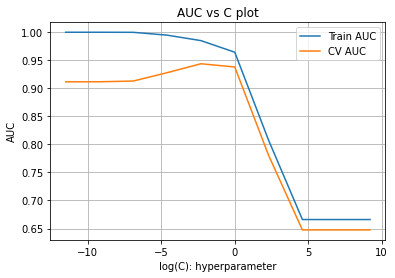

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(b),train_auc,label='Train AUC')
plt.plot(np.log(b),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
c=b
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)
local_c=list(c[i] for i in l)
print(f'all local differences {local_diff}')
print(f'all local max C {local_c}')

for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_c=c[l[v]]
print(f'best C to use = {c[l[v]]}')

all local differences [0.041260964409675416]
all local max C [0.1]
best cv score to use = 0.9437125827105811
best C to use = 0.1


In [0]:
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

L_SVM_L2=SGDClassifier(loss='hinge', penalty='l2', alpha=beat_c, n_jobs=-1)
L_SVM_L2.fit(X_train,y_train)
y_pred_tr = L_SVM_L2.decision_function(X_train)
y_pred_ts = L_SVM_L2.decision_function(X_test)

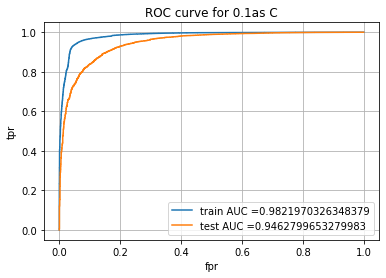

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.7642270825517644 for threshold 0.667
train
the maximum value of tpr*(1-fpr) 0.8902701061598797 for threshold 0.772


train Confusion Matrix


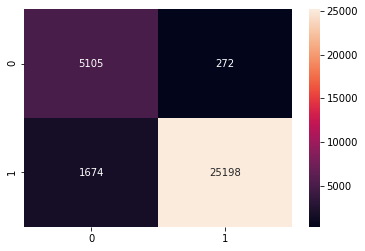

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


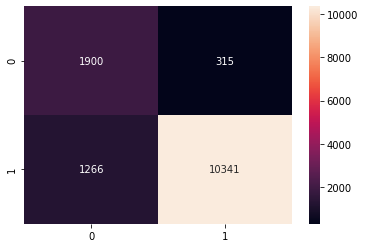

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 88.56%
Precision on test set: 97.04%
recall score on test set: 89.09%
f1 score on test set: 92.90%


In [0]:
count=0
value=[]
for i in L_SVM_L1.coef_.reshape(-1,1):
  count+=1
  value.extend(i)

x=vectorizer.get_feature_names()

features= pd.DataFrame({'feature_name':x,'value':value})

Top Most important features

In [0]:
features.sort_values(by = ['value'], ascending=False).head(10)

,feature_name,value
0,ability,0.0
3330,pots,0.0
3337,poured,0.0
3336,pour,0.0
3335,pounds,0.0
3334,pound bag,0.0
3333,pound,0.0
3332,pouches,0.0
3331,pouch,0.0
3329,potential,0.0


Least Most important features

In [0]:
features.sort_values(by = ['value'], ascending=True).head(10)

,feature_name,value
275,bark,-2.258169
0,ability,0.000000
3336,pour,0.000000
3335,pounds,0.000000
3334,pound bag,0.000000
3333,pound,0.000000
3332,pouches,0.000000
3331,pouch,0.000000
3330,pots,0.000000
3329,potential,0.000000


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

#### L1 Reg

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(sent_vectors,final['Score'].values,test_size=0.3,random_state=0)


ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(32249, 50)
(13822, 50)


In [0]:
b=[10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

param = {'alpha':b}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

L_SVM_L1=SGDClassifier(loss='hinge', penalty='l1', n_jobs=-1)
temp_gscv= GridSearchCV(L_SVM_L1,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.1s finished


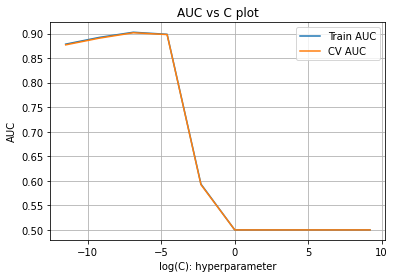

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(b),train_auc,label='Train AUC')
plt.plot(np.log(b),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
c=b
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)
local_c=list(c[i] for i in l)
print(f'all local differences {local_diff}')
print(f'all local max C {local_c}')

for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_c=c[l[v]]
print(f'best C to use = {c[l[v]]}')

all local differences [0.0010622737464192067]
all local max C [0.001]
best cv score to use = 0.9015297579354975
best C to use = 0.001


In [0]:
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

L_SVM_L1=SGDClassifier(loss='hinge', penalty='l1', alpha=best_c, n_jobs=-1)
L_SVM_L1.fit(X_train,y_train)
y_pred_tr = L_SVM_L1.decision_function(X_train)
y_pred_ts = L_SVM_L1.decision_function(X_test)

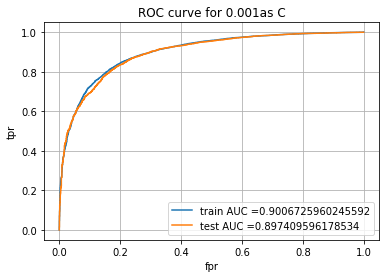

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.6663495854937698 for threshold 0.98
train
the maximum value of tpr*(1-fpr) 0.6793984810542605 for threshold 1.053


train Confusion Matrix


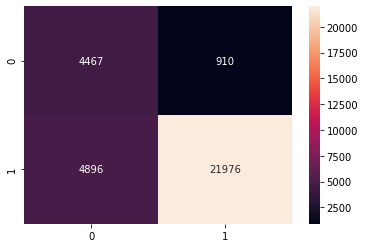

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


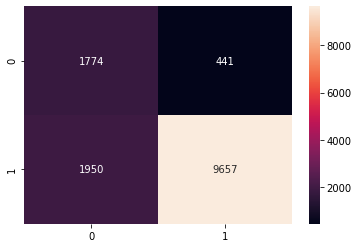

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 82.70%
Precision on test set: 95.63%
recall score on test set: 83.20%
f1 score on test set: 88.98%


L2 Reg

In [0]:
b=[10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

param = {'alpha':b}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

L_SVM_L2=SGDClassifier(loss='hinge', penalty='l2', n_jobs=-1)
temp_gscv= GridSearchCV(L_SVM_L2,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.3s finished


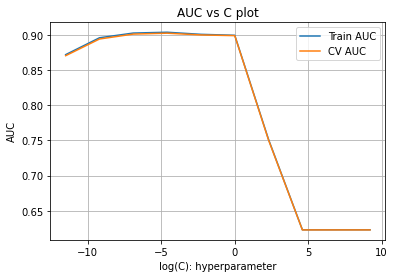

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(b),train_auc,label='Train AUC')
plt.plot(np.log(b),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
c=b
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)
local_c=list(c[i] for i in l)
print(f'all local differences {local_diff}')
print(f'all local max C {local_c}')

for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_c=c[l[v]]
print(f'best C to use = {c[l[v]]}')

all local differences [0.0013415658003620434]
all local max C [0.01]
best cv score to use = 0.902334007508338
best C to use = 0.01


In [0]:
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

L_SVM_L2=SGDClassifier(loss='hinge', penalty='l2', alpha=best_c, n_jobs=-1)
L_SVM_L2.fit(X_train,y_train)
y_pred_tr = L_SVM_L2.decision_function(X_train)
y_pred_ts = L_SVM_L2.decision_function(X_test)

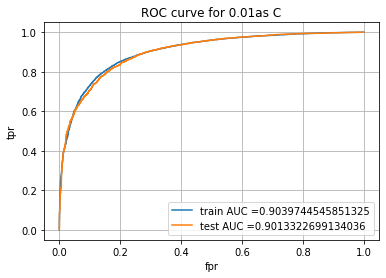

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.676080033435105 for threshold 1.004
train
the maximum value of tpr*(1-fpr) 0.6856755682564691 for threshold 0.97


train Confusion Matrix


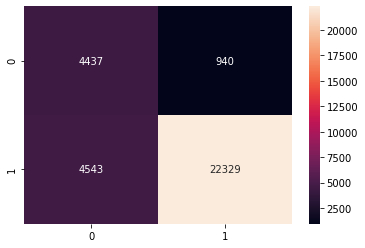

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


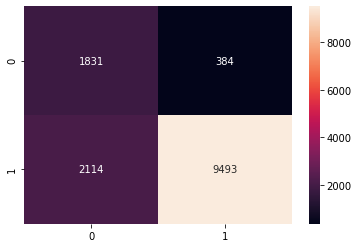

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 81.93%
Precision on test set: 96.11%
recall score on test set: 81.79%
f1 score on test set: 88.37%


### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

#### L1 Reg

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(tfidf_sent_vectors,final['Score'].values,test_size=0.3,random_state=0)


ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(32249, 50)
(13822, 50)


In [0]:
b=[10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

param = {'alpha':b}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

L_SVM_L1=SGDClassifier(loss='hinge', penalty='l1', n_jobs=-1)
temp_gscv= GridSearchCV(L_SVM_L1,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.5s finished


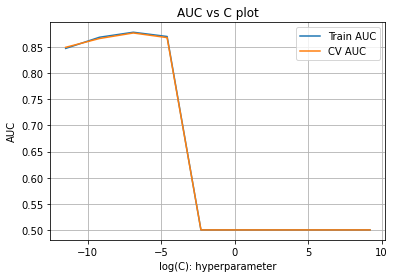

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(b),train_auc,label='Train AUC')
plt.plot(np.log(b),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
c=b
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)
local_c=list(c[i] for i in l)
print(f'all local differences {local_diff}')
print(f'all local max C {local_c}')

for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_c=c[l[v]]
print(f'best C to use = {c[l[v]]}')

all local differences [0.0014173315360446193]
all local max C [0.001]
best cv score to use = 0.876876553316813
best C to use = 0.001


In [0]:
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

L_SVM_L1=SGDClassifier(loss='hinge', penalty='l1', alpha=best_c, n_jobs=-1)
L_SVM_L1.fit(X_train,y_train)
y_pred_tr = L_SVM_L1.decision_function(X_train)
y_pred_ts = L_SVM_L1.decision_function(X_test)

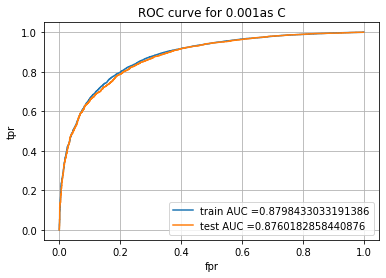

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.6324649191028765 for threshold 1.043
train
the maximum value of tpr*(1-fpr) 0.640449854697959 for threshold 1.043


train Confusion Matrix


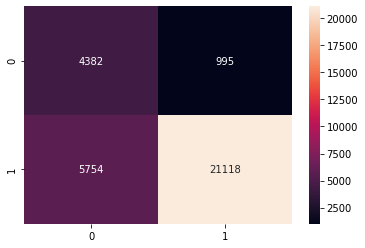

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


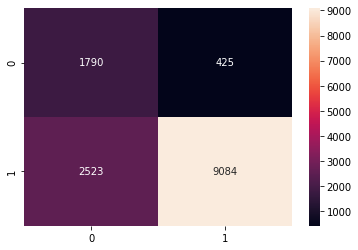

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 78.67%
Precision on test set: 95.53%
recall score on test set: 78.26%
f1 score on test set: 86.04%


#### L2 Reg

In [0]:
b=[10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

param = {'alpha':b}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

L_SVM_L2=SGDClassifier(loss='hinge', penalty='l2', n_jobs=-1)
temp_gscv= GridSearchCV(L_SVM_L2,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    7.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.8s finished


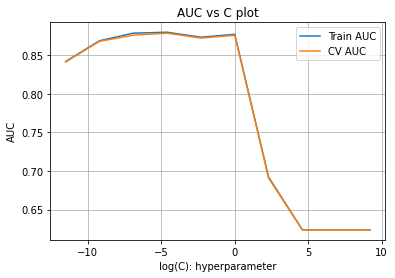

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(b),train_auc,label='Train AUC')
plt.plot(np.log(b),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
c=b
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)
local_c=list(c[i] for i in l)
print(f'all local differences {local_diff}')
print(f'all local max C {local_c}')

for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_c=c[l[v]]
print(f'best C to use = {c[l[v]]}')

all local differences [0.0013099793793687198, 0.0012198394920496236]
all local max C [1, 0.01]
best cv score to use = 0.87849406502283
best C to use = 0.01


In [0]:
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

L_SVM_L2=SGDClassifier(loss='hinge', penalty='l2', alpha=best_c, n_jobs=-1)
L_SVM_L2.fit(X_train,y_train)
y_pred_tr = L_SVM_L2.decision_function(X_train)
y_pred_ts = L_SVM_L2.decision_function(X_test)

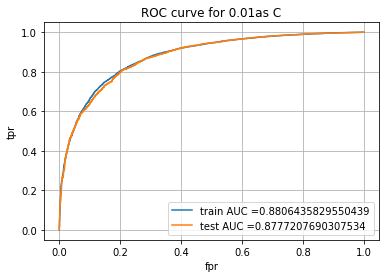

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.6404870105433769 for threshold 0.965
train
the maximum value of tpr*(1-fpr) 0.643737830016295 for threshold 0.989


train Confusion Matrix


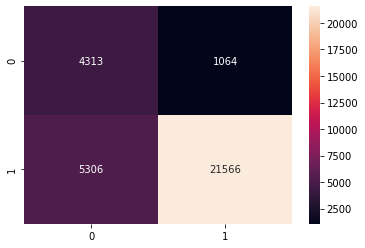

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


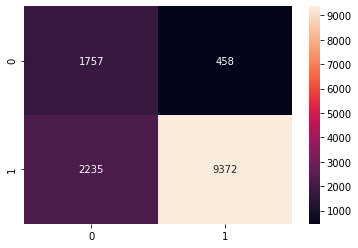

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 80.52%
Precision on test set: 95.34%
recall score on test set: 80.74%
f1 score on test set: 87.44%


## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews[:20000],final['Score'].values[:20000],test_size=0.3,random_state=0)

vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10,max_features=500)
vectorizer.fit(X_train) 
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(14000, 500)
(6000, 500)


In [0]:
b=[10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

param = {'C':b, 'gamma':b}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

RBF_SVM=SVC(kernel='rbf',max_iter=800)

temp_gscv= GridSearchCV(RBF_SVM,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05], 'gamma': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05]}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 49.3min finished


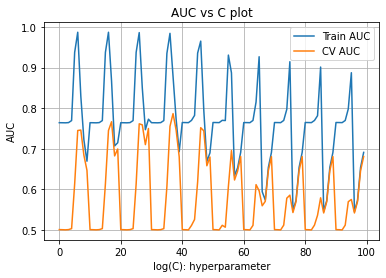

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(range(100),train_auc,label='Train AUC')
plt.plot(range(100),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV scores that is maximas then using the one which is least distant then its AUC counter part to derive  
# C and gamma to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
c=b #using same range for gamma and C
local_max=()
diff=x-y

#finding index of maximas of CV scores 
local_max_i=argrelextrema(y, np.greater)

#generating a list of indexs for maximas
l=list(i for i in local_max_i[0])

#generating list of indices in neighbor of maximas to check
k=[]
neighbor=0
for i in l:
  if i >neighbor and i<len(y):
    k.extend(range(i-neighbor,i+neighbor+1))
  elif i<neighbor and i < len(y):
    k.extend(range(i,i+neighbor+1))
  else:
    k.extend(range(i-neighbor,i+1))
l=k

# diff between CV and Test AUC at the local maximas
local_diff=list(diff[i] for i in l)
print(f'all local differences {local_diff}')

#fetching the index where local diff is min
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')


best_index= l[v]

# as index are in range of 0 to hundread 
# for differnt permutation of C and gamma
# fetching the C and Gamma index from them

best_c=c[int((best_index-(best_index%10))/10)]
print(f'best C to use = {best_c}')

best_gamma=c[best_index%10]
print('best gamma to use = {}'.format(best_gamma))

print('best index {}'.format(best_index))

all local differences [0.0834623601955713, 0.10006505771777519, 0.01539573816249773, 0.22435269068589936, 0.022905877932908325, 0.09145052288214106, 0.2129380824187166, 0.010095279105655552, 0.25819505010344845, 0.19102607837807672, 0.01029692736678156, 0.203281699021849, 0.010233541078124797, 0.3282732965647418, 0.010206030387288179, 0.3216317564551193, 0.010206030387288179, 0.31179566712224316]
best cv score to use = 0.6799018907274256
best C to use = 1
best gamma to use = 1e-05
best index 49


In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc
from sklearn.svm import SVC

RBF_SVM=SVC(kernel='rbf',C=best_c,gamma=best_gamma)

RBF_SVM.fit(X_train,y_train)
y_pred_tr = RBF_SVM.decision_function(X_train)
y_pred_ts = RBF_SVM.decision_function(X_test)

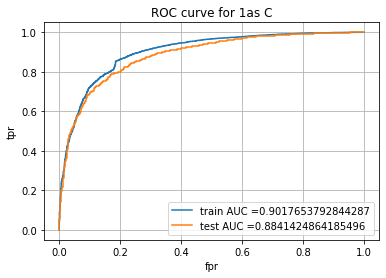

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.6530735915784356 for threshold 1.002
train
the maximum value of tpr*(1-fpr) 0.6949123921867554 for threshold 1.0


train Confusion Matrix


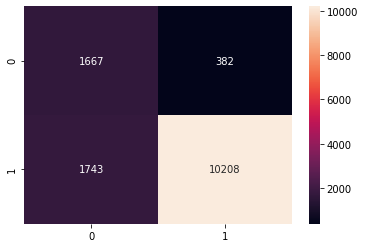

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


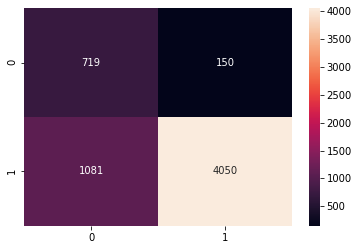

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 79.48%
Precision on test set: 96.43%
recall score on test set: 78.93%
f1 score on test set: 86.81%


### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews[:20000],final['Score'].values[:20000],test_size=0.3,random_state=0)

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)
vectorizer.fit(X_train) 
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(14000, 500)
(6000, 500)


In [0]:
b=[10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

param = {'C':b, 'gamma':b}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

RBF_SVM=SVC(kernel='rbf',max_iter=800)

temp_gscv= GridSearchCV(RBF_SVM,param,cv=3,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05], 'gamma': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 30.4min finished


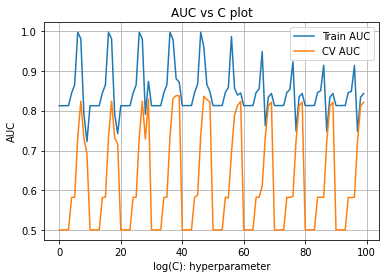

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(range(100),train_auc,label='Train AUC')
plt.plot(range(100),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV scores that is maximas then using the one which is least distant then its AUC counter part to derive  
# C and gamma to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
c=b #using same range for gamma and C
local_max=()
diff=x-y

#finding index of maximas of CV scores 
local_max_i=argrelextrema(y, np.greater)

#generating a list of indexs for maximas
l=list(i for i in local_max_i[0])

#generating list of indices in neighbor of maximas to check
k=[]
neighbor=1
for i in l:
  if i >neighbor and i<len(y):
    k.extend(range(i-neighbor,i+neighbor+1))
  elif i<neighbor and i < len(y):
    k.extend(range(i,i+neighbor+1))
  else:
    k.extend(range(i-neighbor,i+1))
dup_less=[]
[dup_less.append(x) for x in k if x not in dup_less] 
l=dup_less

# diff between CV and Test AUC at the local maximas
local_diff=list(diff[i] for i in l)
print(f'all local differences {local_diff}')

#fetching the index where local diff is min
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')


best_index= l[v]

# as index are in range of 0 to hundread 
# for differnt permutation of C and gamma
# fetching the C and Gamma index from them

best_c=c[int((best_index-(best_index%10))/10)]
print(f'best C to use = {best_c}')

best_gamma=c[best_index%10]
print('best gamma to use = {}'.format(best_gamma))


all local differences [0.26296280773073133, 0.1566328908460144, 0.060229057767497984, 0.26296280773073133, 0.1566328908460144, 0.060229057767497984, 0.26296280773073133, 0.1566328908460144, 0.06190633158216985, 0.04426459917875758, 0.3109896414449488, 0.14761350387962924, 0.042444196436403514, 0.03422955383792914, 0.25892680242917754, 0.12470751026543281, 0.037300489567466566, 0.3111297271696932, 0.26238006181091333, 0.27686638753664206, 0.025718629060782927, 0.02138096244174803, 0.3112587787149147, 0.021650092023007828, 0.02188229819671461, 0.3113440499392851, 0.3110444559453227, 0.2625528727821933, 0.27010136515947136, 0.022261332959500946, 0.021678079084481272, 0.3114293211636554, 0.2624550966704735, 0.26646015872202466, 0.33062381211176384, 0.0222206219616341, 0.021678079084481272, 0.3114293211636554, 0.3111297271696932, 0.26241907494806327, 0.26578882573394724]
best cv score to use = 0.8228827904449189
best C to use = 0.1
best gamma to use = 1e-05


In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc
from sklearn.svm import SVC

RBF_SVM=SVC(kernel='rbf',C=best_c,gamma=best_gamma)

RBF_SVM.fit(X_train,y_train)
y_pred_tr = RBF_SVM.decision_function(X_train)
y_pred_ts = RBF_SVM.decision_function(X_test)

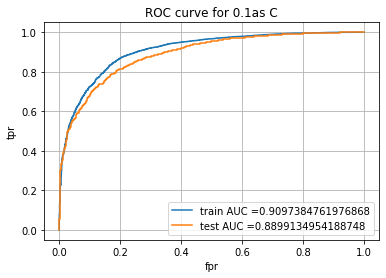

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.6536589457479851 for threshold 1.0
train
the maximum value of tpr*(1-fpr) 0.6966342433163824 for threshold 1.0


train Confusion Matrix


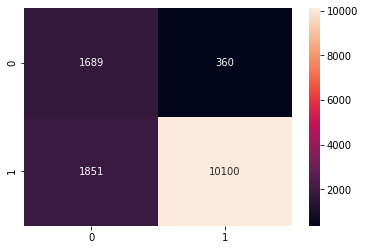

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


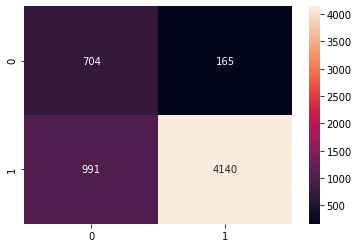

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 80.73%
Precision on test set: 96.17%
recall score on test set: 80.69%
f1 score on test set: 87.75%


### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(sent_vectors[:20000],final['Score'].values[:20000],test_size=0.3,random_state=0)


ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(14000, 50)
(6000, 50)


In [0]:
b=[10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

param = {'C':b, 'gamma':b}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

RBF_SVM=SVC(kernel='rbf', max_iter=800)

temp_gscv= GridSearchCV(RBF_SVM,param,cv=3,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05], 'gamma': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.4min finished


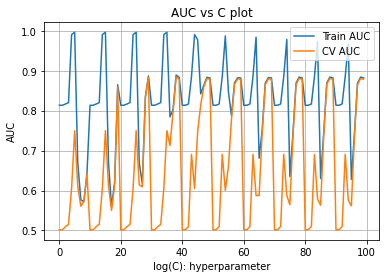

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(range(100),train_auc,label='Train AUC')
plt.plot(range(100),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV scores that is maximas then using the one which is least distant then its AUC counter part to derive  
# C and gamma to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
c=b #using same range for gamma and C
local_max=()
diff=x-y

#finding index of maximas of CV scores 
local_max_i=argrelextrema(y, np.greater)

#generating a list of indexs for maximas
l=list(i for i in local_max_i[0])

#generating list of indices in neighbor of maximas to check
k=[]
neighbor=1
for i in l:
  if i >neighbor and i<len(y):
    k.extend(range(i-neighbor,i+neighbor+1))
  elif i<neighbor and i < len(y):
    k.extend(range(i,i+neighbor+1))
  else:
    k.extend(range(i-neighbor,i+1))
dup_less=[]
[dup_less.append(x) for x in k if x not in dup_less] 
l=dup_less

# diff between CV and Test AUC at the local maximas
local_diff=list(diff[i] for i in l)
print(f'all local differences {local_diff}')

#fetching the index where local diff is min
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')


best_index= l[v]

# as index are in range of 0 to hundread 
# for differnt permutation of C and gamma
# fetching the C and Gamma index from them

best_c=c[int((best_index-(best_index%10))/10)]
print(f'best C to use = {best_c}')

best_gamma=c[best_index%10]
print('best gamma to use = {}'.format(best_gamma))


all local differences [0.38542643977787083, 0.24636934992867143, 0.059422645172685695, -2.730328435152085e-05, 0.0011412068883860371, 0.3120450311756736, 0.38542643977787083, 0.24636934992867143, 0.059422645172685695, 0.007930452858324166, 0.005010827710314469, 0.3120450311756736, 0.38542643977787083, 0.24636934992867143, 0.05481535548856231, 4.2507799765334475e-05, 0.003358117440158903, 0.3120450311756736, 0.38542643977787083, 0.24636934992867143, 0.07176317892560657, 0.005452634895622088, 0.005212610586675215, 0.004092749233788773, 0.30711276610798244, 0.19445899945428735, 0.38560331478561827, 0.0042152124962759885, 0.0034365068080162153, 0.0033011323204528153, 0.3069312498985801, 0.19445899945428735, 0.3865876924342865, 0.003788197177292063, 0.003245905954156969, 0.003277232733068014, 0.30686545364589957, 0.1944588769458595, 0.39670806703903916, 0.004191477742078398, 0.003255299052406624, 0.003277232733068014, 0.306833165550924, 0.194459106602069, 0.3909884584273121, 0.0040713673470

In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc
from sklearn.svm import SVC

RBF_SVM=SVC(kernel='rbf', C=best_c, gamma=best_gamma)

RBF_SVM.fit(X_train,y_train)
y_pred_tr = RBF_SVM.decision_function(X_train)
y_pred_ts = RBF_SVM.decision_function(X_test)

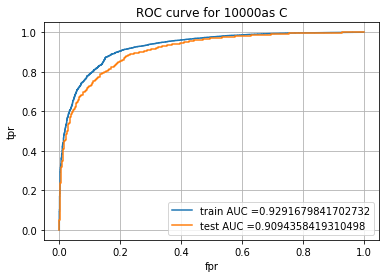

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.6858771980777956 for threshold 0.868
train
the maximum value of tpr*(1-fpr) 0.7398401942142224 for threshold 0.981


train Confusion Matrix


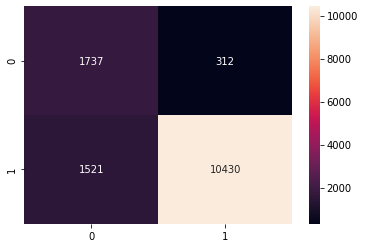

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


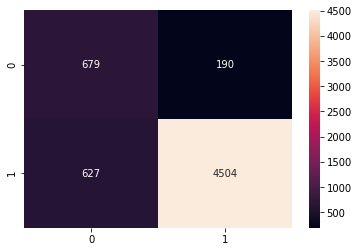

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 86.38%
Precision on test set: 95.95%
recall score on test set: 87.78%
f1 score on test set: 91.68%


### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(tfidf_sent_vectors[:20000],final['Score'].values[:20000],test_size=0.3,random_state=0)


ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(14000, 50)
(6000, 50)


In [0]:
b=[10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

param = {'C':b, 'gamma':b}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

RBF_SVM=SVC(kernel='rbf',max_iter=800)

temp_gscv= GridSearchCV(RBF_SVM,param,cv=3,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05], 'gamma': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.5min finished


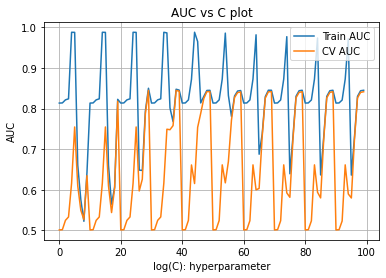

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(range(100),train_auc,label='Train AUC')
plt.plot(range(100),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV scores that is maximas then using the one which is least distant then its AUC counter part to derive  
# C and gamma to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
c=b #using same range for gamma and C
local_max=()
diff=x-y

#finding index of maximas of CV scores 
local_max_i=argrelextrema(y, np.greater)

#generating a list of indexs for maximas
l=list(i for i in local_max_i[0])

#generating list of indices in neighbor of maximas to check
k=[]
neighbor=1
for i in l:
  if i >neighbor and i<len(y):
    k.extend(range(i-neighbor,i+neighbor+1))
  elif i<neighbor and i < len(y):
    k.extend(range(i,i+neighbor+1))
  else:
    k.extend(range(i-neighbor,i+1))
dup_less=[]
[dup_less.append(x) for x in k if x not in dup_less] 
l=dup_less

# diff between CV and Test AUC at the local maximas
local_diff=list(diff[i] for i in l)
print(f'all local differences {local_diff}')

#fetching the index where local diff is min
for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')


best_index= l[v]

# as index are in range of 0 to hundread 
# for differnt permutation of C and gamma
# fetching the C and Gamma index from them

best_c=c[int((best_index-(best_index%10))/10)]
print(f'best C to use = {best_c}')

best_gamma=c[best_index%10]
print('best gamma to use = {}'.format(best_gamma))


all local differences [0.37137437939844153, 0.23275790771579996, 0.05114094070827524, -0.004152691125847374, 0.007386309472876773, 0.3120781512272939, 0.37137437939844153, 0.23275790771579996, 0.05114094070827524, 0.0028975196724085883, 0.004577958440894481, 0.3120781512272939, 0.37137437939844153, 0.23275790771579996, 0.05129694274818042, 0.006235896870168012, 0.005172455983185831, 0.3120781512272939, 0.37137437939844153, 0.23703939489642933, 0.053776981214547215, 0.009977141886247543, 0.003004623476214441, 0.0027314138854953596, 0.29645958393483807, 0.2110710693637179, 0.37224512473646, 0.005360878719183004, 0.002891717206916722, 0.0032619784794545303, 0.2967339490619092, 0.21110024568593944, 0.3684513778211208, 0.003769763885777988, 0.003633496969732808, 0.3120781512272939, 0.29696455845151903, 0.2111003069439975, 0.38152373293007646, 0.0038299715260168288, 0.0035176885516648992, 0.3120781512272939, 0.29719025452928216, 0.2111009808672244, 0.3843390384870443, 0.00411004221381539, 0.

In [0]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc
from sklearn.svm import SVC

RBF_SVM=SVC(kernel='rbf',C=best_c,gamma=best_gamma)

RBF_SVM.fit(X_train,y_train)
y_pred_tr = RBF_SVM.decision_function(X_train)
y_pred_ts = RBF_SVM.decision_function(X_test)

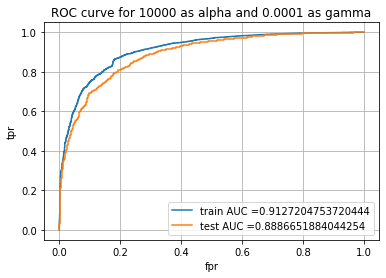

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+' as alpha and '+str (best_gamma)+' as gamma')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.6507299321639557 for threshold 1.093
train
the maximum value of tpr*(1-fpr) 0.7066142335963603 for threshold 0.981


train Confusion Matrix


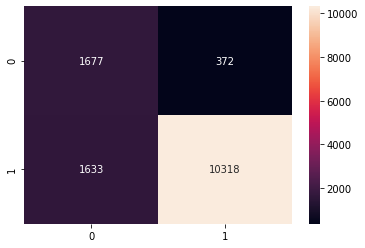

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


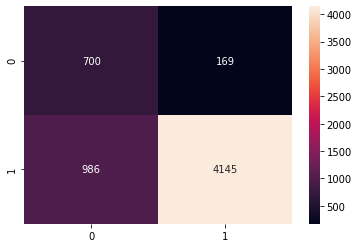

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 80.75%
Precision on test set: 96.08%
recall score on test set: 80.78%
f1 score on test set: 87.77%


In [0]:
print("Tabulation of results for LINEAR SVM")
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["S.NO.", "MODEL",  "alpha value", "Penalty","Test AUC","Precision Score"]
x.add_row(["1", "BOW", "0.001", "L1","0.8991","95.70%"])
x.add_row(["", "", "0.1", "L2","0.9322","96.95%"])
x.add_row(["2", "TFIDF","0.001", "L1","0.9000","83.98%"])
x.add_row(["", "", "0.1", "L2","0.9462","97.04%"])
x.add_row(["3", "AVG W2V", "0.001", "L1","0.8974","95.63%"])
x.add_row(["", "", "0.01", "L2","0.9013","96.11%"])
x.add_row(["4", "TFIDF W2V", "0.001", "L1","0.8760","95.53%"])
x.add_row(["", "","0.01", "L2","0.8777","95.34%"])
print(x)

Tabulation of results for LINEAR SVM
+-------+-----------+-------------+---------+----------+-----------------+
| S.NO. |   MODEL   | alpha value | Penalty | Test AUC | Precision Score |
+-------+-----------+-------------+---------+----------+-----------------+
|   1   |    BOW    |    0.001    |    L1   |  0.8991  |      95.70%     |
|       |           |     0.1     |    L2   |  0.9322  |      96.95%     |
|   2   |   TFIDF   |    0.001    |    L1   |  0.9000  |      83.98%     |
|       |           |     0.1     |    L2   |  0.9462  |      97.04%     |
|   3   |  AVG W2V  |    0.001    |    L1   |  0.8974  |      95.63%     |
|       |           |     0.01    |    L2   |  0.9013  |      96.11%     |
|   4   | TFIDF W2V |    0.001    |    L1   |  0.8760  |      95.53%     |
|       |           |     0.01    |    L2   |  0.8777  |      95.34%     |
+-------+-----------+-------------+---------+----------+-----------------+


In [0]:
print("Tabulation of results for RBF SVM")
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["S.NO.", "MODEL",  "alpha value", "gamma","Test AUC","Precision Score"]
x.add_row(["1", "BOW", "0.001", "0.00001","0.8841","96.43%"])
x.add_row(["2", "TFIDF","0.1", "0.00001","0.8899","96.17%"])
x.add_row(["3", "AVG W2V", "10000", "0.0001","0.9094","95.95%"])
x.add_row(["4", "TFIDF W2V", "10000", "0.0001","0.8886","96.08%"])
print(x)

Tabulation of results for RBF SVM
+-------+-----------+-------------+---------+----------+-----------------+
| S.NO. |   MODEL   | alpha value |  gamma  | Test AUC | Precision Score |
+-------+-----------+-------------+---------+----------+-----------------+
|   1   |    BOW    |    0.001    | 0.00001 |  0.8841  |      96.43%     |
|   2   |   TFIDF   |     0.1     | 0.00001 |  0.8899  |      96.17%     |
|   3   |  AVG W2V  |    10000    |  0.0001 |  0.9094  |      95.95%     |
|   4   | TFIDF W2V |    10000    |  0.0001 |  0.8886  |      96.08%     |
+-------+-----------+-------------+---------+----------+-----------------+


In [0]:
!sudo apt-get install pandoc texlive-xetex
!jupyter nbconvert --to pdf SVM.ipynb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-extra texlive-latex-recommended texlive-pictures
  texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japan